# MidcurveLLM Fine-tuning with CodeT5 Hugging Face Transformers

🙌 Welcome to the hands-on tutorial dedicated for building an Fine-tuned model for Geometric Graphs Shape Reduction aka Midcurve.

A bit more info about MidcurveNN: MidcurveNN is a project aimed at solving the challenging problem of finding the midcurve of a 2D closed shape using neural networks. The primary goal is to transform a closed polygon, represented by a set of points or connected lines, into another set of points or connected lines, allowing for the possibility of open or branched polygons in the output.

👉👉 Step-by-step explanation of the solution is available [here TBD]().


## Installations

Let's first install the required libraries:
* HuggingFace Transformers (for the CodeT5 model)
* HuggingFace Datasets (for loading the dataset + preprocessing it)
* PyTorch Lightning (for training)
* Weights and Biases (for logging training metrics).

In [1]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.1 MB/s eta 0:00:00


In [2]:
!pip install -q pytorch-lightning wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.8/258.8 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.9 MB/s eta 0:00:00


## Dataset
Data in the form of csv is made avilable at the Github location [here](https://raw.githubusercontent.com/yogeshhk/MidcurveNN/master/src/codeT5/data/all.csv). `wget` it ones from the location given below. Keep it in `data` folder, then comment this cell for further executions.

## Preprocess data

Here, we load the csv files to create a dataset.

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# os.chdir('/content/drive/MyDrive/ImpDocs/Work/AICoach/Notebooks')

In [4]:
!pip install wget
import wget

# Replace the URL with the raw URL of the file on GitHub
url_midcurve_llm = "https://raw.githubusercontent.com/yogeshhk/MidcurveNN/master/src/codeT5/data/midcurve_llm.csv"
url_midcurve_llm_test = "https://raw.githubusercontent.com/yogeshhk/MidcurveNN/master/src/codeT5/data/midcurve_llm_test.csv"
url_midcurve_llm_train = "https://raw.githubusercontent.com/yogeshhk/MidcurveNN/master/src/codeT5/data/midcurve_llm_train.csv"
url_midcurve_llm_val = "https://raw.githubusercontent.com/yogeshhk/MidcurveNN/master/src/codeT5/data/midcurve_llm_val.csv"

# Download the file
wget.download(url_midcurve_llm, 'midcurve_llm.csv')
wget.download(url_midcurve_llm_test, 'midcurve_llm_test.csv')
wget.download(url_midcurve_llm_train, 'midcurve_llm_train.csv')
wget.download(url_midcurve_llm_val, 'midcurve_llm_val.csv')

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=ba021af290442ef9e708428c47893c83ecac7bd7e243acde90292fb38cb76d85
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


'midcurve_llm_val.csv'

In [5]:
!ls

midcurve_llm.csv  midcurve_llm_test.csv  midcurve_llm_train.csv  midcurve_llm_val.csv


In [6]:
from datasets import load_dataset, Dataset, DatasetDict

base_url = "./"
dataset = load_dataset("csv", data_files={"train": base_url + "midcurve_llm_train.csv",
                                          "test": base_url + "midcurve_llm_test.csv",
                                          "validation": base_url + "midcurve_llm_val.csv"})
print(dataset)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['ShapeName', 'Profile', 'Midcurve', 'Profile_brep', 'Midcurve_brep'],
        num_rows: 793
    })
    test: Dataset({
        features: ['ShapeName', 'Profile', 'Midcurve', 'Profile_brep', 'Midcurve_brep'],
        num_rows: 99
    })
    validation: Dataset({
        features: ['ShapeName', 'Profile', 'Midcurve', 'Profile_brep', 'Midcurve_brep'],
        num_rows: 100
    })
})


A crucial step in our journey involves the compilation of a dataset that mirrors the real-world profiles. So, this dataset is a `Profile_brep` and corresponding `Midcurve_brep` dataset. Each row in the dataset consists of an:
- `Profile_brep` that describes a 2D Profile in brep format
- `Midcurve_brep` that describes the correspondng 1D Midcurve in brep format

Let's look at one particular example:

In [7]:
example = dataset['train'][0]

print("Profile_brep:", example["Profile_brep"])
print("Midcurve_brep:", example["Midcurve_brep"])

Profile_brep: "{\"Points\": [[-3.21, 6.3], [-1.67, 11.06], [-15.93, 15.69], [-17.48, 10.94]], \"Lines\": [[0, 1], [1, 2], [2, 3], [3, 0]], \"Segments\": [[0, 1, 2, 3]]}"
Midcurve_brep: "{\"Points\": [[-2.44, 8.68], [-16.7, 13.31]], \"Lines\": [[0, 1]], \"Segments\": [[0]]}"


The goal for the model is to generate Midcurve Brep from given Profile Brep.

To summarize:
* input: code, which is turned into `input_ids` + `attention_mask`
* output: docstrings, which are turned into `labels` (which are the `input_ids` of the docstrings).

Below, we define a `preprocess_examples` function, which we can apply on the entire dataset.

In [8]:
from transformers import RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained("Salesforce/codet5-small")

prefix = "Skeletonize the Profile: "
max_input_length = 256
max_target_length = 128

def preprocess_examples(examples):
  # encode the code-docstring pairs
  profiles = examples['Profile_brep']
  midcurves = examples['Midcurve_brep']

  inputs = [prefix + profile for profile in profiles]
  model_inputs = tokenizer(inputs, max_length=max_input_length, padding="max_length", truncation=True)

  # encode the summaries
  labels = tokenizer(midcurves, max_length=max_target_length, padding="max_length", truncation=True).input_ids

  # important: we need to replace the index of the padding tokens by -100
  # such that they are not taken into account by the CrossEntropyLoss
  labels_with_ignore_index = []
  for labels_example in labels:
    labels_example = [label if label != 0 else -100 for label in labels_example]
    labels_with_ignore_index.append(labels_example)

  model_inputs["labels"] = labels_with_ignore_index

  return model_inputs

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Now that we have defined the function, let's call `.map()` on the HuggingFace Dataset object, which allows us to apply this function in batches (by default a batch size of 1,000 is used!) - hence super fast.

In [9]:
dataset = dataset.map(preprocess_examples, batched=True)

Map:   0%|          | 0/793 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ShapeName', 'Profile', 'Midcurve', 'Profile_brep', 'Midcurve_brep', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 793
    })
    test: Dataset({
        features: ['ShapeName', 'Profile', 'Midcurve', 'Profile_brep', 'Midcurve_brep', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 99
    })
    validation: Dataset({
        features: ['ShapeName', 'Profile', 'Midcurve', 'Profile_brep', 'Midcurve_brep', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})

Next, let's set the format to "torch" and create PyTorch dataloaders.

In [11]:
from torch.utils.data import DataLoader

dataset.set_format(type="torch", columns=['input_ids', 'attention_mask', 'labels'])
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=8)
valid_dataloader = DataLoader(dataset['validation'], batch_size=4)
test_dataloader = DataLoader(dataset['test'], batch_size=4)

In [12]:
batch = next(iter(train_dataloader))
print(batch.keys())

dict_keys(['input_ids', 'attention_mask', 'labels'])


Let's verify an example, by decoding it back into text:

In [13]:
tokenizer.decode(batch['input_ids'][0])

'<s>Skeletonize the Profile: "{\\"Points\\": [[-4.16, 5.72], [-3.37, 10.66], [-18.19, 13.01], [-18.97, 8.07]], \\"Lines\\": [[0, 1], [1, 2], [2, 3], [3, 0]], \\"Segments\\": [[0, 1, 2, 3]]}"</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [14]:
labels = batch['labels'][0]
tokenizer.decode([label for label in labels if label != -100])

'<s>"{\\"Points\\": [[-3.77, 8.19], [-18.58, 10.54]], \\"Lines\\": [[0, 1]], \\"Segments\\": [[0]]}"</s>'

## Fine-tune using PyTorch Lightning

As we will train the model using PyTorch Lightning, we first need to define a `LightningModule`, which is an `nn.Module` with some additional functionalities. We just need to define the `forward` pass, `training_step` (and optionally `validation_step` and `test_step`), and the corresponding dataloaders. PyTorch Lightning will then automate the training for us, handling device placement (i.e. we don't need to type `.to(device)` anywhere), etc. It also comes with support for loggers (such as Tensorboard, Weights and Biases) and callbacks.

Of course, you could also train the model in other ways:
* using regular PyTorch
* using the HuggingFace Trainer (in this case, the Seq2SeqTrainer)
* using HuggingFace Accelerate
* etc.

In [26]:
from transformers import T5ForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl

class CodeT5(pl.LightningModule):
    def __init__(self, lr=5e-5, num_train_epochs=100, warmup_steps=1000):
        super().__init__()
        self.model_name = "Salesforce/codet5-small"
        self.model = T5ForConditionalGeneration.from_pretrained(self.model_name)
        self.save_hyperparameters()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return outputs

    def common_step(self, batch, batch_idx):
        outputs = self(**batch)
        loss = outputs.loss

        return loss

    def training_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss, on_epoch=True)

        return loss

    def test_step(self, batch, batch_idx):
        loss = self.common_step(batch, batch_idx)

        return loss

    def configure_optimizers(self):
        # create optimizer
        optimizer = AdamW(self.parameters(), lr=self.hparams.lr)
        # create learning rate scheduler
        num_train_optimization_steps = self.hparams.num_train_epochs * len(train_dataloader)
        lr_scheduler = {'scheduler': get_linear_schedule_with_warmup(optimizer,
                                                    num_warmup_steps=self.hparams.warmup_steps,
                                                    num_training_steps=num_train_optimization_steps),
                        'name': 'learning_rate',
                        'interval':'step',
                        'frequency': 1}

        return {"optimizer": optimizer, "lr_scheduler": lr_scheduler}

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return valid_dataloader

    def test_dataloader(self):
        return test_dataloader

Let's start up Weights and Biases!

In [27]:
import wandb

wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

Next, we initialize the model.

In [28]:
model = CodeT5()

We can now simply start training on Colab's GPU.




In [31]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

wandb_logger = WandbLogger(name='codet5-finetune-midcurve', project='CodeT5')
# for early stopping, see https://pytorch-lightning.readthedocs.io/en/1.0.0/early_stopping.html?highlight=early%20stopping
early_stop_callback = EarlyStopping(
    monitor='validation_loss',
    patience=3,
    strict=False,
    verbose=False,
    mode='min'
)
lr_monitor = LearningRateMonitor(logging_interval='step')

trainer = Trainer(max_epochs=100,accelerator="auto", #gpus=1,
                  default_root_dir="./Checkpoints",
                  logger=wandb_logger,
                  callbacks=[early_stop_callback, lr_monitor])
trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 60.5 M
-----------------------------------------------------
60.5 M    Trainable params
0         Non-trainable params
60.5 M    Total params
241.969   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Once we're done training, we can also save the HuggingFace model as follows:

In [32]:
save_directory = "./Checkpoints" # save in the current working directory, you can change this of course
model.model.save_pretrained(save_directory)

This allows us to easily load the trained model again using the `from_pretrained()` method, as shown below.

## Inference

Now that we've trained a model, let's test it on some examples from the test set.

In [33]:
dataset_infr = load_dataset("csv", data_files={"train": base_url + "midcurve_llm_train.csv",
                                          "test": base_url + "midcurve_llm_test.csv",
                                          "validation": base_url + "midcurve_llm_val.csv"})
print(dataset_infr['test'])

Dataset({
    features: ['ShapeName', 'Profile', 'Midcurve', 'Profile_brep', 'Midcurve_brep'],
    num_rows: 99
})


In [34]:
test_example = dataset_infr['test'][2]
print("Profile_brep:", test_example['Profile_brep'])

Profile_brep: "{\"Points\": [[-6.96, 1.23], [-9.83, 5.32], [-22.12, -3.28], [-19.25, -7.38]], \"Lines\": [[0, 1], [1, 2], [2, 3], [3, 0]], \"Segments\": [[0, 1, 2, 3]]}"


In [97]:
test_examples = [dataset_infr['test'][i] for i in range(2)]
test_examples

[{'ShapeName': 'L_translated_28',
  'Profile': '"[[33.0, 33.0], [38.0, 33.0], [38.0, 58.0], [63.0, 58.0], [63.0, 63.0], [33.0, 63.0]]"',
  'Midcurve': '"[[35.5, 33.0], [35.5, 60.5], [63.0, 60.5]]"',
  'Profile_brep': '"{\\"Points\\": [[33.0, 33.0], [38.0, 33.0], [38.0, 58.0], [63.0, 58.0], [63.0, 63.0], [33.0, 63.0]], \\"Lines\\": [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0]], \\"Segments\\": [[0, 1, 2, 3, 4, 5]]}"',
  'Midcurve_brep': '"{\\"Points\\": [[35.5, 33.0], [35.5, 60.5], [63.0, 60.5]], \\"Lines\\": [[0, 1], [1, 2]], \\"Segments\\": [[0, 1]]}"'},
 {'ShapeName': 'L_rotated_10',
  'Profile': '"[[4.06, 5.79], [8.98, 6.66], [4.64, 31.28], [29.26, 35.62], [28.39, 40.55], [-1.15, 35.34]]"',
  'Midcurve': '"[[6.52, 6.23], [1.74, 33.31], [28.82, 38.08]]"',
  'Profile_brep': '"{\\"Points\\": [[4.06, 5.79], [8.98, 6.66], [4.64, 31.28], [29.26, 35.62], [28.39, 40.55], [-1.15, 35.34]], \\"Lines\\": [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0]], \\"Segments\\": [[0, 1, 2, 3, 4, 5]]}"

## Visualization

In [98]:
import json
import matplotlib.pyplot as plt

def plot_brep(brep_str,segment_color = 'black',  marker='o'):
    brep = json.loads(brep_str)
    brep = json.loads(brep)
    point_list = brep['Points']
    x_coords, y_coords = zip(*point_list)
    segments = brep["Segments"]
    lines = brep["Lines"]
    for segment in segments:
        for line_idx in segment:
            line = lines[line_idx]
            x_segment = [x_coords[i] for i in line]
            y_segment = [y_coords[i] for i in line]
            plt.plot(x_segment + [x_segment[0]], y_segment + [y_segment[0]],
                     color=segment_color, marker=marker)

def plot_breps(shapes_brep_dict_list):
    for dct in shapes_brep_dict_list:
        profile_brep_str = dct['Profile_brep']
        # plot_brep(profile_brep_str,segment_color = 'black',  marker='o')
        # midcurve_brep_str = json.loads(dct['Midcurve_brep'])
        # plot_brep(midcurve_brep_str,segment_color = 'red',  marker='x')
        # plt.axis('equal')
        profile_brep = json.loads(profile_brep_str)
        profile_brep = json.loads(profile_brep)
        profile_point_list = profile_brep['Points']
        profile_x_coords, profile_y_coords = zip(*profile_point_list)
        profile_segments = profile_brep["Segments"]
        profile_lines = profile_brep["Lines"]
        profile_segment_color = 'black'
        # Plot Profile segments
        for segment in profile_segments:
            for line_idx in segment:
                line = profile_lines[line_idx]
                x_segment = [profile_x_coords[i] for i in line]
                y_segment = [profile_y_coords[i] for i in line]
                plt.plot(x_segment + [x_segment[0]], y_segment + [y_segment[0]], color=profile_segment_color,
                         marker='o')


        midcurve_brep_str = json.loads(dct['Midcurve_brep'])
        midcurve_brep = json.loads(midcurve_brep_str)
        # midcurve_brep = json.loads(midcurve_brep)
        midcurve_point_list = midcurve_brep['Points']
        midcurve_x_coords, midcurve_y_coords = zip(*midcurve_point_list)
        midcurve_segments = midcurve_brep["Segments"]
        midcurve_lines = midcurve_brep["Lines"]
        midcurve_segment_color = 'red'

        # Plot Midcurve segments
        for segment in midcurve_segments:
            for line_idx in segment:
                line = midcurve_lines[line_idx]
                x_segment = [midcurve_x_coords[i] for i in line]
                y_segment = [midcurve_y_coords[i] for i in line]
                plt.plot(x_segment + [x_segment[0]], y_segment + [y_segment[0]], color=midcurve_segment_color,
                         marker='x')

        plt.axis('equal')

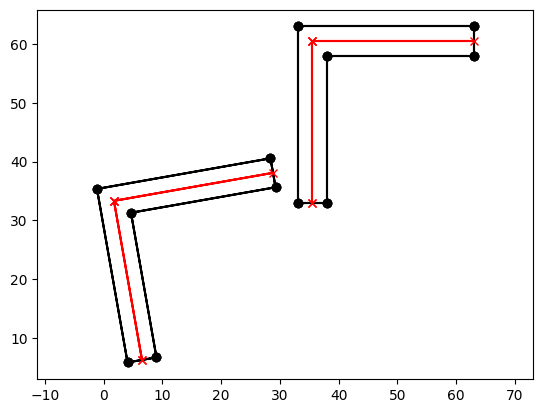

In [99]:
plot_breps(test_examples)

We can load our trained model as follows:

In [100]:
from transformers import T5ForConditionalGeneration

model = T5ForConditionalGeneration.from_pretrained(save_directory)

We can prepare the example using `RobertaTokenizer`, and generate using the `.generate()` method. Note that there are several ways of doing generation (greedy decoding/beam search/top k sampling/etc.), for that I refer to Patrick's blog post which you can find [here](https://huggingface.co/blog/how-to-generate). Here we will just use the default settings (i.e. greedy decoding).

In [79]:
# prepare for the model
input_ids = tokenizer(test_example['Profile_brep'], return_tensors='pt').input_ids
# generate
outputs = model.generate(input_ids, max_new_tokens=200)
Midcurve_brep_str_Predicted = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Generated Midcurve:", Midcurve_brep_str_Predicted)

Generated Midcurve: [[-8.59, 3.14], [-21.3, -5.26]], \"Lines\": [[0, 1]], \"Segments\": [[0]]}"


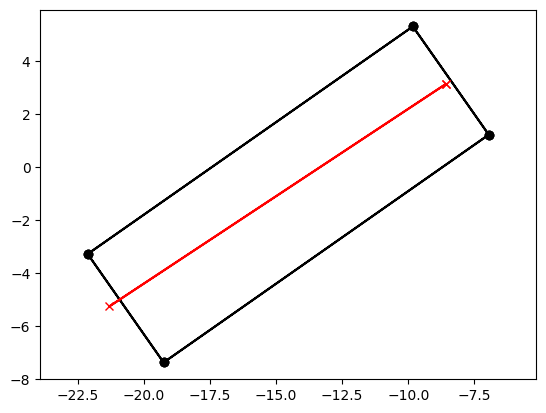

In [95]:
import copy
test_example_predicted = copy.deepcopy(test_example)
test_example_predicted['Midcurve_brep'] = '"{\\"Points\\": ' + Midcurve_brep_str_Predicted
test_example_predicted
plot_breps([test_example_predicted])

Let's compare this to the ground-truth docstring:




In [40]:
print("Ground truth:", test_example['Midcurve_brep'])

Ground truth: "{\"Points\": [[-8.4, 3.28], [-20.68, -5.33]], \"Lines\": [[0, 1]], \"Segments\": [[0]]}"


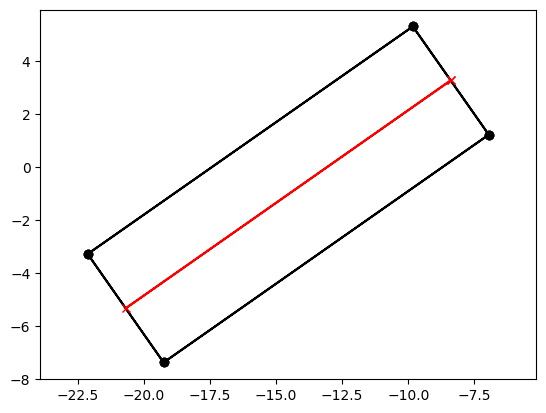

In [96]:
plot_breps([test_example])

## Upload trained model to the hub

Cool! We can also share our model with the world, by uploading it to [hf.co](https://hf.co). For that, we need to install Git-LFS, which is used for using git with large files (note that each model on the hub = a git repository!).

In [ ]:
# !sudo apt-get install git-lfs
# !git config --global user.email "yogeshkulkarni@yahoo.com"
# !git config --global user.name "Yogesh Kulkarni"

Next, we can login with the credentials of our HuggingFace account (you can sign up on [hf.co](https://hf.co) if you haven't already!).

In [ ]:
# !huggingface-cli login

In [ ]:
# repo_url = "https://huggingface.co/yogeshhk/finetune_t5_midcurve"

In [ ]:
# from huggingface_hub import Repository

# repo = Repository(local_dir="checkpoint", # note that this directory must not exist already
#                   clone_from=repo_url,
#                   git_user="Yogesh Kulkarni",
#                   git_email="yogeshkulkarni@yahoo.com",
#                   use_auth_token=True,
# )

In [ ]:
# model.save_pretrained("/content/checkpoint")
# tokenizer.save_pretrained("/content/checkpoint")

In [ ]:
# push to hub
# repo.push_to_hub(commit_message="First commit")